<a href="https://colab.research.google.com/github/sayakgis/dog_breed_kaggle/blob/master/Fastai_DogBreed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Identification
## Building Image Classification CNN model using Fastai on Google Colab platform




### This is a computer vision application of identification of breed of dog by using images. The dataset is from [Kaggle competetion.](https://www.kaggle.com/c/dog-breed-identification)

## Problem Statement:
Who's a good dog? Who likes ear scratches? Well, it seems those fancy deep neural networks don't have all the answers. However, maybe they can answer that ubiquitous question we all ask when meeting a four-legged stranger: what kind of good pup is that?

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/border_collies.png)

## Project Description:



*  The notebook expalins step by step process to build CNN model that can identify the breed of the dog from image
*   We will use Fastai libraries, Fastai uses Pytorch as a background deep learning framework.

*   I encourge the visitor to read to end of this notebook to gain complete understanding of building world class image classifier using deep learning
*   Special thanks to Jeremy Howard for his awosome training on Fastai



### Installtion FASTAI 0.7.0 and Pytorch 0.2.3 version and configuring Google Colab for FastAI

In [0]:
#This part of the code is required for configuring colab with fastai course version
!pip uninstall fastai  -q
!pip install Pillow==4.1.1  -q
!pip install "fastai==0.7.0"  -q
!pip install torchtext==0.2.3  -q
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python  -q
import cv2 
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag  
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())  
!apt update && apt install -y libsm6 libxext6  -q

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision  -q
import torch
!pip install image -q

In [7]:
# Check python version
import sys
sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [0]:
# Incase need to restart kernel
#!kill -9 -1 

In [0]:
#Automatic reload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Import FastAI Libraries

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.dataset import *

### Install Kaggle CLI and get the Kaggle Competetion data

In [0]:
#Kaggle CLI
!pip install --upgrade kaggle-cli -q

## Dataloading:
We will download the dataset from Kaggle CLI to Google Colab machine. After data downlaoding small configuration is required:


*   Unzip the data to folder name called **data**, this is required for using Fastai on dataset

*   Remove the zip files just to create sufficient space on colab

*   Directory structure should be: **data/dataset name/**, inside this train and test folders must be kept






In [0]:
#Downlaod the dataset
!kg download -u sayakchakraborty -p removed -c dog-breed-identification -q

In [145]:
#Check the root directory
!ls

labels.csv  sample_submission.csv  test  tmp  train


In [0]:
#Unzip the data to required folder
!mkdir data
!unzip train.zip -d 'data/dogbreed/' -q
!unzip test.zip -d 'data/dogbreed/'  -q
!unzip labels.csv.zip -d 'data/dogbreed/'  -q 
!unzip sample_submission.csv.zip -d 'data/dogbreed/'   -q

#Remove the zip files from root directory
!rm test.zip
!rm train.zip
!rm labels.csv.zip
!rm sample_submission.csv.zip

**How does the directory look like now?**

In [146]:
# set directory path
PATH='data/dogbreed/'
# list of directories inside path
os.listdir(PATH)

['train', 'tmp', 'sample_submission.csv', 'labels.csv', 'test']

**Load the labels and explore**

In [41]:
labels=f'{PATH}labels.csv'
# Number of records in training data
n=len(list(open(labels)))-1  #Header is counted henece -1
print('Number of training data:',n)

Number of training data: 10222


### Create Validation data
The datset contains training and test data folder and labels in csv file. We would like to create a validation dataset (20%) out of 10222 images, which we shall use for checking the accuracy of the model

In [0]:
val_idx=get_cv_idxs(n)  #20% of the data kept randomly for validation

In [148]:
print('Number of validation data:',len(val_idx))

Number of validation data: 2044


## Data Exploration:

We will explore the data provided in the dog breed identification problem

In [153]:
# Check the data folder contains
!ls {PATH}
#shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

labels.csv  sample_submission.csv  test  train


**Populate the labels in a dataframe**

In [154]:
df=pd.read_csv(labels)
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


**Observations**: The dataframe contains id and breed type field, the id column has file name of the images. But file name does not have suffix of file type like** .jpg**

**How many type of breeds are there in the dataset?**

In [155]:
df_breed=df.groupby('breed').count().sort_values('id',ascending=False)
print('Number of breed types in dataset:',len(df_breed))
df_breed

Number of breed types in dataset: 120


,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


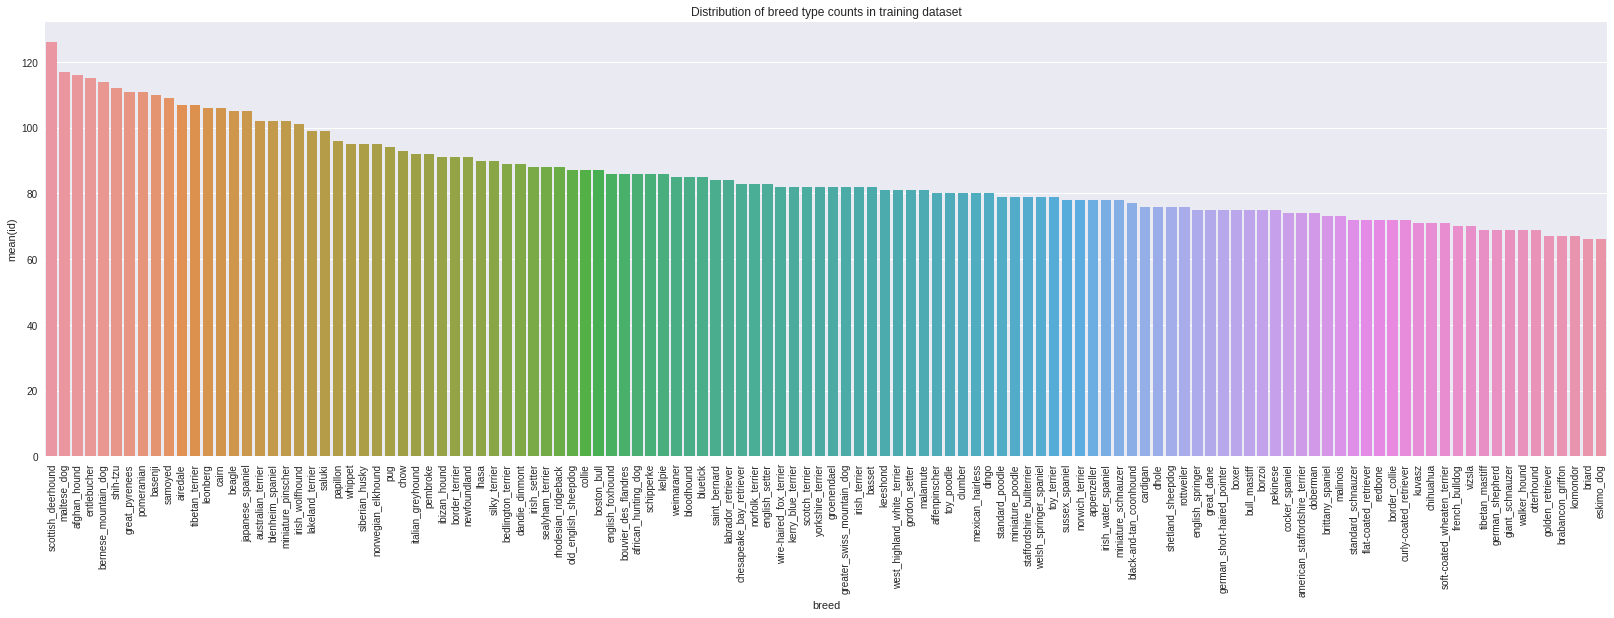

In [156]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#plot to understand the distrbution of classes
plt.figure(figsize=(28,8))
sns.barplot(x=df_breed.index,y='id',data=df_breed)
a=np.arange(len(df_breed))
plt.xticks(a,(df_breed.index),rotation=90)
plt.title('Distribution of breed type counts in training dataset')
plt.show()

**Observation:**

-There are 120 type of dog breeds available in this training data set.

-The dataset is having distribution of 66 to 126 count variation, which looks good. Hence we will not consider it as imbalnce dataset.

**Let us see the dataset images and the breeds types**

In [157]:
#take 10 files
files=os.listdir(f'{PATH}train')[:10]
print(files)

['f3929a0a7c3fede11ceb5d9e379778db.jpg', '818b791ea3cb6202fac3319ce285f41f.jpg', '055cfac66e5d67756ab05d02baeeb04c.jpg', '45c500a40d2bc460ed48337a8893ebc5.jpg', 'f523e20f7fac8e1d9909d0956a468467.jpg', 'a3c86eed8bd50060f0d3e8d03c600087.jpg', 'f811a192eb721accaa495e6722d9acff.jpg', '69406cd21bac290f6c6eaa6b0a968fc1.jpg', 'd9fec2e53835b302c7c5d1d6803eb4f2.jpg', '39483e8221f9e7455abcc9d0097688e5.jpg']


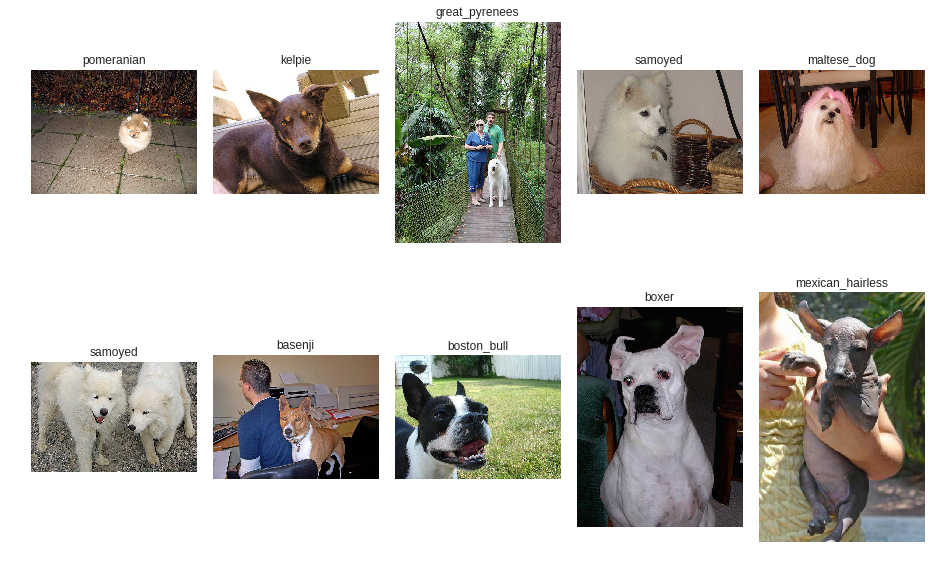

In [158]:
#Let us open 10 images and see their labels
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.1,wspace=0.1)
for i,j in enumerate(files):
  plt.subplot(2,5,(i+1))
  f=plt.imread(PATH+'train/'+files[i])
  plt.imshow(f)
  plt.axis("Off")
  plt.title(str(list(df.loc[df.id==files[i][:-4]]['breed']))[2:-2])

**Set basics parameters like size of image, batch size and predefined models**
 
**We will use* Resnet34* to start with**

In [0]:
sz=64    #size of the image
bs=58    #batch size for mini-batching
arch=resnet34    # we will use resnet34 model as our architechure

**Let us create the data object for Fastai**


1.   We will create data with data augmentation: In Fastai library brightness and contrasts are automatically randomised.
2.   For data augmentation we are chossing side on flipping and with zoom of 1.1




In [0]:
#Transformation for training data set with side on and zoom 1.1
tfms=tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)

#Data object, here the labels are stored in csv so we shall use from_csv function
data=ImageClassifierData.from_csv(path=PATH,              #location of the data
                                  folder='train',         #training dataset location
                                  csv_fname=labels,       #loading the labels from csv
                                  tfms=tfms,              #using transforms defined early
                                  val_idxs=val_idx,       #validation dataset of 20% defined early
                                  test_name='test',       #test folder name as we shall submit the data to kaggle
                                  bs=bs,                  #batch size
                                  suffix='.jpg')          #the labels in the csv does not have file extention so we are passing this suffix

**Let us check if we can fetch the imges from data object**

In [161]:
fn=PATH+data.trn_ds.fnames[22]
fn

'data/dogbreed/train/00f34ac0a16ef43e6fd1de49a26081ce.jpg'

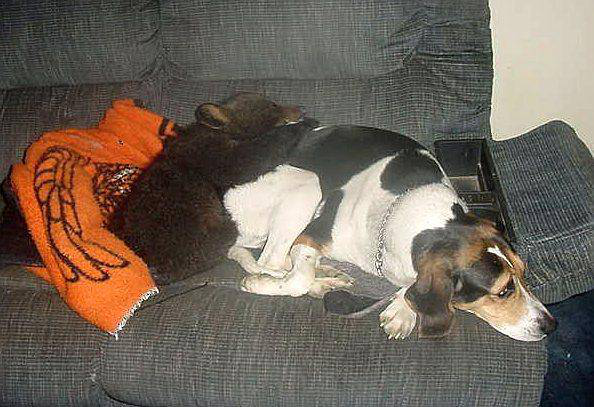

In [162]:
img=PIL.Image.open(fn)
img

In [163]:
print('Size of the image:',img.size)

Size of the image: (594, 407)


**Let us try to understand the size distribution of the images in the training dataset**

Create a dictonary for size of image images

In [0]:
size_d={k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

Create ndarray of row and column size of images

In [0]:
row_sz,col_sz=list(zip(*size_d.values()))
row_sz=np.array(row_sz)
col_sz=np.array(col_sz)

Check values of row and col sizes

In [166]:
row_sz[:5]

array([500, 500, 500, 500, 500])

In [167]:
col_sz[:5]

array([375, 375, 500, 375, 470])

**Plot histogram to understand distribution of row and column size of images**

**Row size**

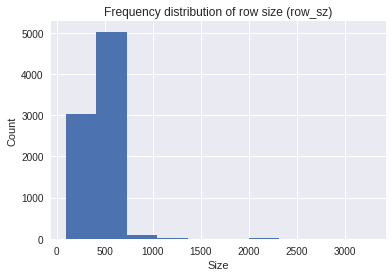

In [168]:
plt.hist(row_sz)
plt.title('Frequency distribution of row size (row_sz)')
plt.xlabel('Size');plt.ylabel('Count')
plt.show()

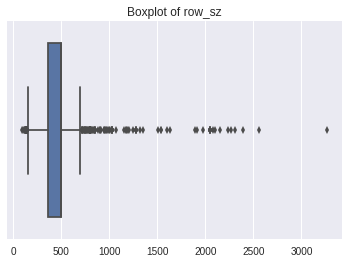

In [169]:
sns.boxplot(row_sz)
plt.title('Boxplot of row_sz')
plt.show()

**There are few outliers let us zoom to the histogram with <1000 row size **

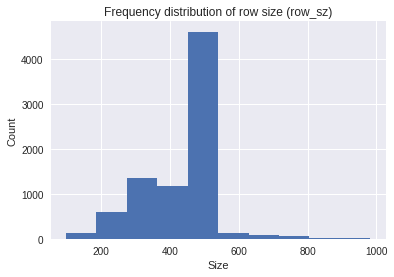

In [170]:
plt.hist(row_sz[row_sz<1000])
plt.title('Frequency distribution of row size (row_sz)')
plt.xlabel('Size');plt.ylabel('Count')
plt.show()

**Column size**

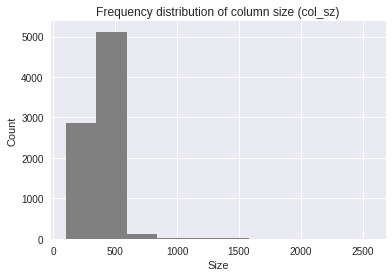

In [171]:
plt.hist(col_sz,color='gray')
plt.title('Frequency distribution of column size (col_sz)')
plt.xlabel('Size');plt.ylabel('Count')
plt.show()

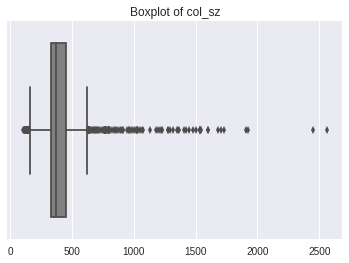

In [172]:
sns.boxplot(col_sz,color='gray')
plt.title('Boxplot of col_sz')
plt.show()

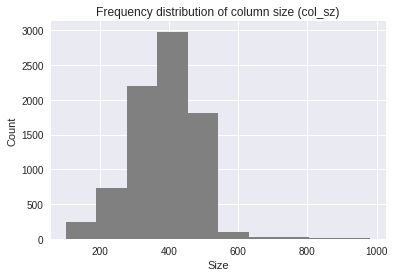

In [173]:
plt.hist(col_sz[col_sz<1000],color='gray')
plt.title('Frequency distribution of column size (col_sz)')
plt.xlabel('Size');plt.ylabel('Count')
plt.show()

**Observation:**
Mode of the two histogram looks close to 500, this means that maximum images has 500 row and column size. We will use this information while fine tuning the model.

**How many images are there in train and test data**

In [174]:
print('No of images in training data:',len(data.trn_ds))
print('No of images in test data:',len(data.test_ds))
print('No of images in validation set:',len(val_idx))
print('No of claases in training data:',len(data.classes))

No of images in training data: 8178
No of images in test data: 10357
No of images in validation set: 2044
No of claases in training data: 120


## Build initial model (Resnet34 as architechture)

**Let us create a function to resize the and get the data, this function will be used to pass size as parameters**

In [0]:
def get_data(sz,bs,arch):  #sz: image size, bs: batch size
  tfms=tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
  data=ImageClassifierData.from_csv(PATH,'train',csv_fname=labels,bs=bs,tfms=tfms,val_idxs=val_idx,suffix='.jpg',test_name='test')
  return data if sz>300 else data.resize(340,'tmp') # reading jpegs and then resizing will take time, so resizing them to 340
  

In [176]:
#Resize the data 224
data=get_data(224,bs,arch)

**Define leaner CNN model at first place we will use the precomputed weights from imagenet dataset**

In [178]:
learn=ConvLearner.pretrained(arch,data,precompute=True)

100%|██████████| 179/179 [01:25<00:00,  3.75it/s]


**Learning rate finder**

With this operation we will try to find the optimum learning rate required for convergence while optimisation loss function

In [179]:
lrf=learn.lr_find()

 92%|█████████▏| 130/141 [00:03<00:00, 47.83it/s, loss=14]  


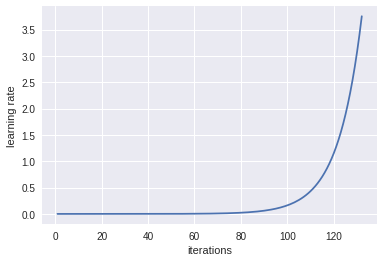

In [180]:
learn.sched.plot_lr()

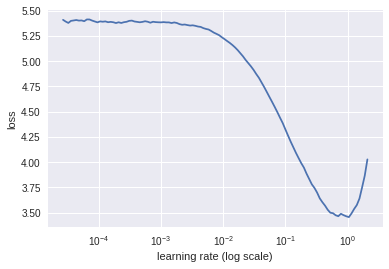

In [181]:
learn.sched.plot()

**Observation:**

learning rate of 1e-1 looks good to start the model fitting

**Fit the model**

In [182]:
learn.fit(1e-1,5)  #learning rate=1e-1 and epoch=5

epoch      trn_loss   val_loss   accuracy   
    0      1.245564   0.742688   0.776908  
    1      0.791727   0.668392   0.804305  
    2      0.587049   0.620337   0.810665  
    3      0.5101     0.666063   0.809687  
    4      0.433842   0.621288   0.824364  



[array([0.62129]), 0.8243639974794742]

**Observation:**

To start with we are getting 83% validation accuracy which looks a good starting point for 120 class dataset

**Let us try to fit the model with precompute=False and stochastic gradient deccent with restart**

In [183]:
learn.precompute=False
learn.fit(1e-1,5,cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.53811    0.571197   0.832192  
    1      0.492888   0.54722    0.837084  
    2      0.474987   0.564374   0.84589   
    3      0.437411   0.539687   0.840509  
    4      0.455899   0.549595   0.838552  



[array([0.5496]), 0.8385518647569966]

**How did stochastics gradient descent with restart is working**

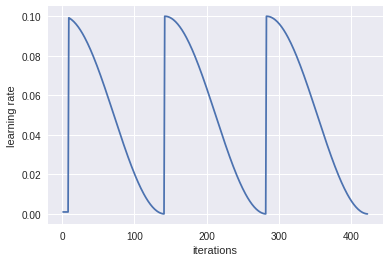

In [189]:
learn.sched.plot_lr()

**Save the model**


In [0]:
learn.save('224_pre')
learn.load('224_pre')

**Observation:**
With precompute is false also there does not seem any significant improvement in accuracy, hence let us try increasing the image size





**Increase the image size to 299**

In [186]:
learn.set_data(get_data(299,bs,arch))

**Train the model**

The model should start learning initiated from smaller size images and now we can pass larger size images

In [187]:
learn.fit(1e-1,3,cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.44844    0.478409   0.86546   
    1      0.430978   0.485631   0.856654  
    2      0.417593   0.475266   0.854207  



[array([0.47527]), 0.854207441998088]

**Observation:**

Increase image size does not contribute the significant improvement of the validation accuracy at this point we could try unfreezing the layers and use differential learing rate, but that may not work for this dataset as they are from ImageNET dataset. 

**Try running one more cycle with 2 epochs.**

In [191]:
learn.fit(1e-1,2,cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.382111   0.482596   0.859589  
    1      0.389239   0.491018   0.858121  



[array([0.49102]), 0.8581213397639138]

**Save the model**

In [0]:
learn.save('299_pre')

**Test time augmentation on validation dataset**

In [195]:
log_pred, y=learn.TTA()

**Check accuracy on validation dataset**

In [208]:
probs=np.mean(np.exp(log_pred),0)
accuracy_np(probs,y),metrics.log_loss(y,probs)

(0.8679060665362035, 0.4508647225558327)

## Observation:

In this process we are able to reach to maximum validation accuracy of 86% which does not seem to be good enough seeing the leader board of kaggle, we will try to give a fresh try with Resnext50 or resnext100 model architechture.

In [0]:
arch=resnext101_64
bs=28   # we will use smaller batchsize as the model is bigger

**Create data for resnext101_64 model**

In [217]:
data=get_data(224,bs,arch)

**Downlod the pretrained models with weights and extract to the fastai folder**

In [0]:
! wget  http://files.fast.ai/models/weights.tgz

In [222]:
!ls

data  lr_plot.png  sample_data	weights.tgz


In [0]:
import tarfile
tar_=tarfile.open('weights.tgz')
tar_.extractall(path='/usr/local/lib/python3.6/dist-packages/fastai/')

In [0]:
# remove the zip file from root
!rm weights.tgz

## Build the model(Resnext101_64)

In [236]:
learn_resnext=ConvLearner.pretrained(arch,data,precompute=True,ps=0.5)  #ps stands for dropout for regularisation

100%|██████████| 370/370 [06:01<00:00,  1.10it/s]


**Learning rate finder**

In [237]:
lrf_rx=learn_resnext.lr_find()

 85%|████████▍ | 249/293 [00:04<00:00, 46.34it/s, loss=9.14]


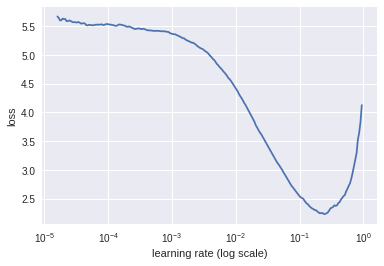

In [239]:
learn_resnext.sched.plot()

**Observation:** 1e-2 looks like a good learning rate

**Fit the model**

In [240]:
learn_resnext.fit(1e-2,5)

epoch      trn_loss   val_loss   accuracy   
    0      0.71095    0.331436   0.896282  
    1      0.439032   0.287284   0.900196  
    2      0.360007   0.267255   0.912916  
    3      0.304982   0.258941   0.913405  
    4      0.285759   0.248856   0.917319  



[array([0.24886]), 0.9173189793547539]

**Precompute is False**

In [0]:
learn_resnext.precompute=False

**Fit the model again**

In [242]:
learn_resnext.fit(1e-2,5,cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.292537   0.239555   0.913894  
    1      0.277926   0.229097   0.921233  
    2      0.28071    0.235872   0.918297  
    3      0.322893   0.242982   0.915851  
    4      0.269565   0.241466   0.917808  



[array([0.24147]), 0.9178082142790703]

Create directory for model

In [0]:
!mkdir '{PATH}models'

In [0]:
!ls {PATH}'/models/'

**Save the model**

In [0]:
learn_resnext.save('224_rxnt')
learn_resnext.load('224_rxnt')

In [267]:
!ls {PATH}'/tmp/340/models'

224_pre.h5  224_rxnt.h5  299_pre.h5  tmp.h5


**Increse the image size and fit again**

In [269]:
data=get_data(299,bs,arch)

In [270]:
learn_resnext.fit(1e-2,5,cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.260936   0.23207    0.923679  
    1      0.254792   0.236342   0.920744  
    2      0.23214    0.237436   0.921233  
    3      0.220692   0.238646   0.920254  
    4      0.247247   0.247135   0.920254  



[array([0.24713]), 0.9202544019646841]

**Observation:**

The validation accuracy is improved but validation loss is less than training loss, this means we are running into underfitting. When we are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly) 

Let us try with cycle_mult=2 with cycle_len=1